# Assignment 2

_by Dmytro Miedviediev 2023-11-16_

**Note**

Plotly plots are interactive if using `.html` format! 

In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import optimize, special, stats
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

warnings.simplefilter("ignore")

# Problem 4

## Task 1 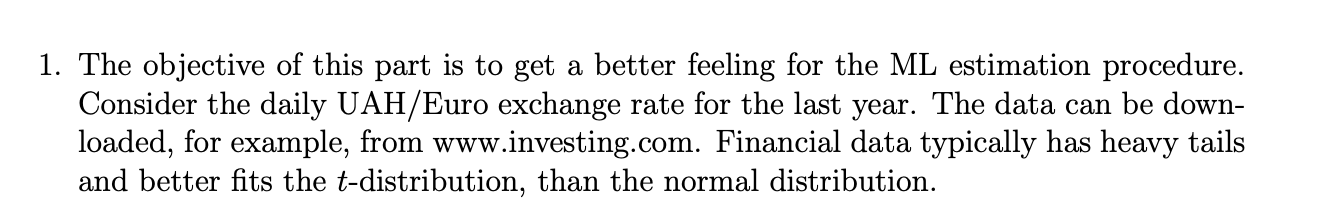

In [2]:
# import historical UAH/Euro exchange rate 15.11.2022-15.11.2023
df_exchange = pd.read_csv("EUR_UAH Historical Data.csv")
df_exchange = df_exchange[["Price", "Date"]]
df_exchange.head(5)

Price        Date
0  39.3420  11/15/2023
1  38.9440  11/14/2023
2  38.6660  11/13/2023
3  38.4516  11/10/2023
4  38.3976  11/09/2023

### a) 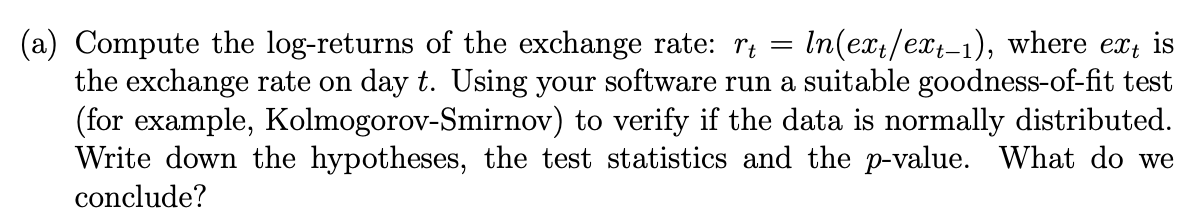

In [3]:
# calculate returns
df_exchange["ln_Price_returns"] = np.log(
    df_exchange["Price"] / df_exchange["Price"].shift(1)
)
df_exchange = df_exchange[1:]
df_exchange.describe()

Price  ln_Price_returns
count  261.000000        261.000000
mean    39.572541         -0.000157
std      0.787005          0.006704
min     37.766600         -0.013943
25%     38.951600         -0.004902
50%     39.576600         -0.000491
75%     40.173100          0.003540
max     41.462300          0.021345

In [4]:
statistic, p_value = stats.kstest(
    df_exchange["ln_Price_returns"] / df_exchange["ln_Price_returns"].std(), "norm"
)

print(f"Statistic: {statistic}")
print("p value: {:.100f}".format(p_value))

Statistic: 0.06520986905798132
p value: 0.2077566606337540866533686312322970479726791381835937500000000000000000000000000000000000000000000000


**Hypotheses:**

H0: Emperical distribution function of log-returns of the exchange rate equals to the function of normally distributed data

H1: Emperical distribution functions are not equal

**Conclusions:**

We can't reject H0 with the confidence less than ~0.21, as p value is a relatively big. So, log-returns of the exchange rate can be normally distributed. Also, from statistic value we can see that the maximum difference between function's values is ~0.065, which is not big enough for us to reject normality.

b) 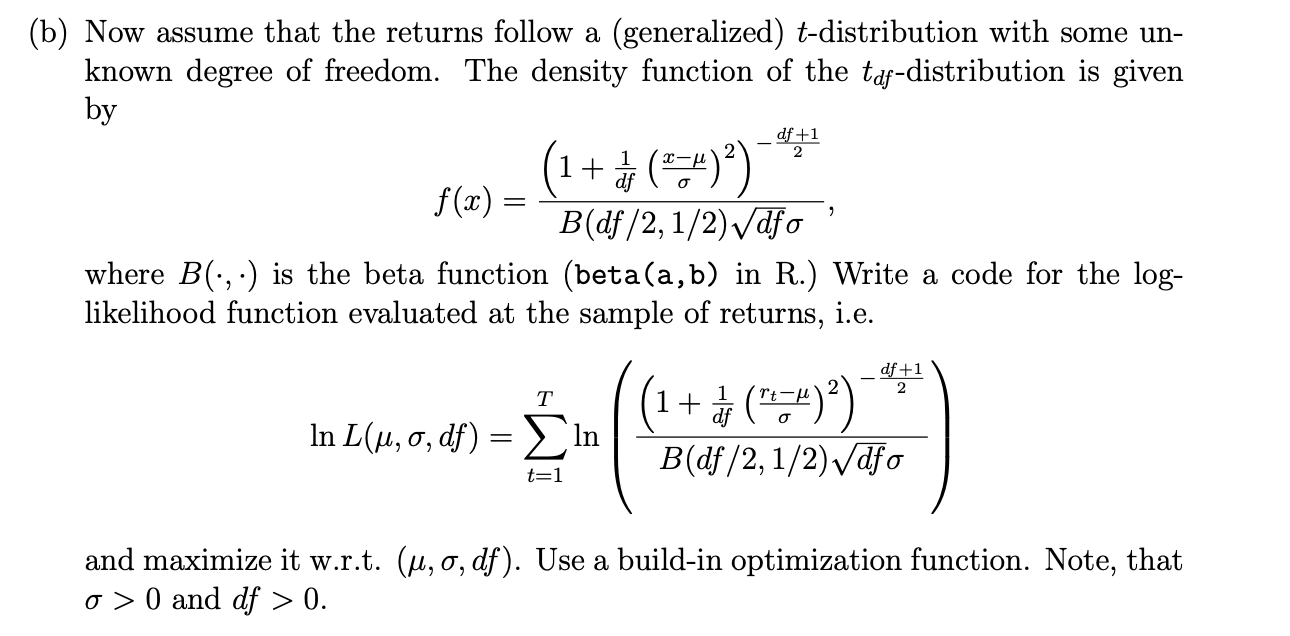

In [5]:
# evaluation function
def log_likelihood(optimization_params, ln_price_returns):
    (mu, sigma, degree_freedom) = optimization_params
    # calculate numerator
    nominator = (
        1 + (1 / degree_freedom) * (((ln_price_returns - mu) / sigma) ** 2)
    ) ** (-1 / 2 * (degree_freedom + 1))
    # calculate denominator
    denominator = (
        special.beta(degree_freedom / 2, 1 / 2) * np.sqrt(degree_freedom) * sigma
    )
    # calculate ln
    ln = np.log(nominator / denominator)
    # return sum and multiply by "-1" to convert problem into minimization
    return -1 * np.sum(ln)

In [6]:
ln_prices = df_exchange["ln_Price_returns"].values

optimization_results = optimize.minimize(
    fun=log_likelihood,  # evaluation function
    x0=(
        1,
        1,
        1,
    ),  # initial parameters to optimize (mu, sigma, degree_freedom)
    args=(ln_prices,),  # data for evaluation
    constraints=(  # constraints on optimization params
        {"type": "ineq", "fun": lambda x: x[1]},  # sigma > 0
        {"type": "ineq", "fun": lambda x: x[2]},  # degree_freedom > 0
    ),
)

print(f"mu: {optimization_results.x[0]}")
print(f"sigma: {optimization_results.x[1]}")
print(f"degree_freedom: {optimization_results.x[2]}")

optimization_results

mu: -0.00028849937292469254
sigma: 0.006358773738551184
degree_freedom: 20.32492450720545


     fun: -936.7782455796128
     jac: array([-1.14741516, -0.47290802,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 161
     nit: 35
    njev: 33
  status: 0
 success: True
       x: array([-2.88499373e-04,  6.35877374e-03,  2.03249245e+01])

**Conclutions:**

We can see that function converges to having optimal degree of freedom ~20, which makes distribution very close to the normal one. This explains the results we got in 1.a

## Task 2 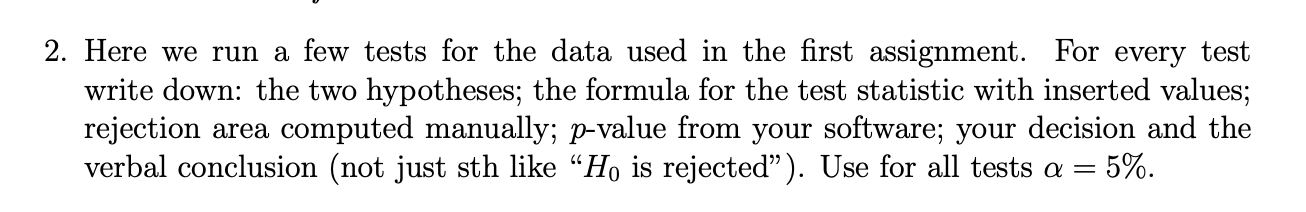

In [7]:
df_ceo = pd.read_csv(
    "ceo.csv",
    delimiter=";",
    decimal=",",
    usecols=["salary", "totcomp", "tenure", "age", "sales", "profits", "assets"],
)
df_ceo.head(5)

salary  totcomp  tenure  age     sales  profits    assets
0    3030     8138       7   61  161315.0   2956.0  257389.0
1    6050    14530       0   51  144416.0  22071.0  237545.0
2    3571     7433      11   63  139208.0   4430.0   49271.0
3    3300    13464       6   60  100697.0   6370.0   92630.0
4   10000    68285      18   63  100469.0   9296.0  355935.0

### a) 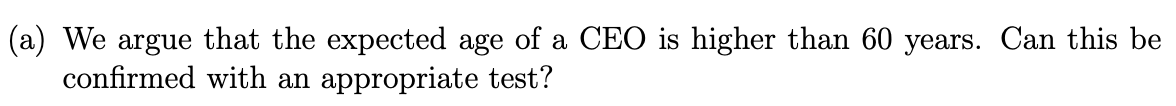

In [8]:
age = df_ceo["age"]

print(f"Stats for age: mu={age.mean()}, n={age.count()}, sigma={age.std(ddof=0)}")

Stats for age: mu=56.46979865771812, n=447, sigma=6.799023202951372


**Hypotheses:** (use right-sided test)

H0: Age of a CEO is not higher than 60 years (<= 60)

H1: Age of a CEO is higher than 60 years (> 60)

**Computations:**

$\alpha = 0.05, \mu = 56.46, \sigma = 6.81 $

$X = N(56.46, 6.81^2)$

$v = \frac{\mu - x}{\sigma} \sqrt{n} = \frac{56.47 - 60}{6.79} \sqrt{447} = -10.98 $

$z_{0.95} = 1.645 $

$B = (1.645; \infty) $ 

$v << z_{0.95}$

In [9]:
mu = age.mean()
sigma = age.std(ddof=0)
sample_size = age.count()

# Calculate the z-test statistic
z_statistic = (mu - 60) / (sigma / (sample_size**0.5))

# Calculate the p-value
p_value = 1 - stats.norm.cdf(z_statistic)

print("z-statistic:", z_statistic)
print("p-value:", p_value)

z-statistic: -10.977582610457409
p-value: 1.0


**Conclusions**:

According to our computations, we see that statistic is much less than the minimum value of rejection area. So, rejection of H0 is not reasonable with any alpha value. This conclusion also are proven with p value magnitude to equal 1, which means that we have not significant clues to reject H0. Totally, we can say that the age of a CEO is not higher than 60 years.

### b) 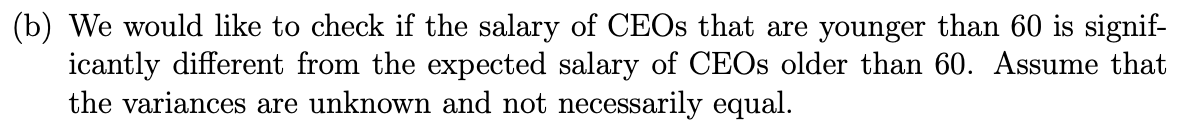

In [10]:
young_salaries = df_ceo[df_ceo["age"] < 60]["salary"]
old_salaries = df_ceo[df_ceo["age"] >= 60]["salary"]

mu_1 = young_salaries.mean()
n_1 = young_salaries.count()
s_1 = young_salaries.std(ddof=1)
mu_2 = old_salaries.mean()
n_2 = old_salaries.count()
s_2 = old_salaries.std(ddof=1)

print(f"Stats for age < 60: mu_1={mu_1}, n_1={n_1}, s_1={s_1}")
print(f"Stats for age >= 60: mu_2={mu_2}, n_2={n_2}, s_2={s_2}")

Stats for age < 60: mu_1=1930.4183673469388, n_1=294, s_1=1676.1364822010298
Stats for age >= 60: mu_2=2214.098039215686, n_2=153, s_2=1799.3503789917374


**Hypotheses:** (use approximate z-test (e))

H0: Mean salary of a CEO with age < 60 equals Mean salary of a CEO with age >= 60 $(\mu_1 = \mu_2)$ 

H1: Mean salary of a CEO with age < 60 not equals Mean salary of a CEO with age >= 60 $(\mu_1 \neq \mu_2)$ 

**Computations:**

$\alpha = 0.05, \mu_1 = 1930.42, \mu_2 = 2214.10, s_1 = 1676.14, s_2 = 1799.35, n_1 = 294, n_2 = 153 $

$v = \frac{\mu_1 - \mu_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} = \frac{1930.42 - 2214.10}{\sqrt{\frac{1676.14^2}{294} + \frac{1799.35^2}{153}}} = \frac{-283.68}{\sqrt{9555.94 + 21161.18}} = -1.62 $

$z_{0.975} = 1.96 $

$B = (-\infty;-1.96) \cup (1.96; \infty) $ 

$-z_{0.975} < v < z_{0.975}$

In [11]:
# Calculate the z-test statistic
z_statistic = (mu_1 - mu_2) / np.sqrt((s_1**2 / n_1) + (s_2**2 / n_2))

# Calculate the p-value
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_statistic)))

print("z-statistic:", z_statistic)
print("p-value:", p_value)

z-statistic: -1.61859509586938
p-value: 0.10553441097612648


**Conclusions**:

According to our computations, we see that statistic is outside of the rejection interval. It means that with the level of significance 5% we can't reject H0. All of the above is also easily deducted from the statistic value, which is close to the interval even with alpha 5%. So making alpha two times bigger make interval reach the statistic value and H0 rejected. Totally, we can say that mean salary of a CEO with age < 60 equals mean salary of a CEO with age >= 60.

### c) 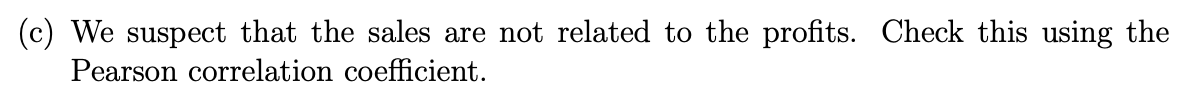

In [12]:
profits = df_ceo["profits"]
sales = df_ceo["sales"]

print(f"Stats for age: mu_x={profits.mean()}, n_x={profits.count()}")
print(f"Stats for age: mu_y={sales.mean()}, n_y={sales.count()}")

Stats for age: mu_x=700.4608501118569, n_x=447
Stats for age: mu_y=11557.780984340045, n_y=447


**Hypotheses:** (use Pearson correlation test)

H0: Sales are not linearly related to the profits $(p = 0)$ 

H1: Sales are linearly related to the profits $(p \neq 0)$

**Computations:**

$\alpha = 0.05, \mu_x = 700.46, \mu_y = 11557.78, n = 447 $

$p = \frac{\sum_{i=1}^{n}(x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum_{i=1}^{n}(x_i - \mu_x)^2\sum_{i=1}^{n}(y_i - \mu_y)^2}} = \frac{\sum_{i=1}^{447}(x_i - 700.46)(y_i - 11557.78)}{\sqrt{\sum_{i=1}^{447}(x_i - 700.46)^2\sum_{i=1}^{447}(y_i - 11557.78)^2}} = \frac{8075244917.347226}{\sqrt{11123384342.911783}} = 0.726 $

$v = \sqrt{n - 2}\frac{p}{\sqrt{1 - p ^ 2}} = \sqrt{445}\frac{0.726}{\sqrt{1 - 0.726 ^ 2}} = 21.095 * 0.688 = 14.507 $

$t_{445;0.975} = 1.965 $

$B = (-\infty;-1.965) \cup (1.965; \infty) $ 

$v >> t_{445;0.975}$

In [13]:
# Calculate the p-value
p, p_value = stats.pearsonr(profits, sales)

print("p:", p)
print("p value: {:.100f}".format(p_value))

p: 0.7259701425756325
p value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000232093812728709592968549695


**Conclusions**:

According to our computations, we see that the Pearson correlation coefficient is far from being zero and statistic value additionally proves that fact. It lays within the rejection interval far from the left maximum value. That means that we reject the H0, stating that the linear relation between features exist.

### d)  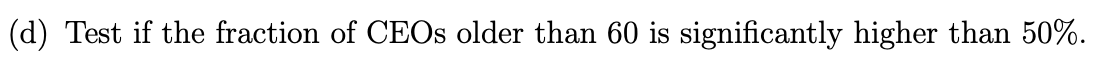

In [14]:
n = df_ceo["age"].count()
n_older = (df_ceo["age"] >= 60).sum()

print(f"Total count: {n}")
print(f"Older 60 count (>=60): {n_older}")

Total count: 447
Older 60 count (>=60): 153


**Hypotheses:** (use left-sided proportion asymptotic z-test)

H0: The fraction of CEOs older than 60 is higher 50% $(p >= 0.5)$ 

H1: The fraction of CEOs older than 60 is less 50% $(p < 0.5)$

**Computations:**

$\alpha = 0.05, n = 447 $

$ 5 \le \sum_{i=1}^{n}(x_i) \le n-5: 5 \le 153 \le 447-5 $

$\mu = \frac{153}{447} = 0.3422 $

$v = \sqrt{n}\frac{\mu - p_0}{\sqrt{p_0(1-p_0)}} = \sqrt{447}\frac{0.3422 - 0.5}{\sqrt{0.5(1-0.5)}} = 21.1424 * -0.3156 = -6.67 $

$N(0;1): z_{0.05} = -1.645 $

$B = (-\infty;-1.645) $ 

$ z_{0.05} > v$

In [15]:
z_statistic, p_value = proportions_ztest(
    n_older, n, value=0.5, prop_var=0.5, alternative="smaller"
)

print("z-statistic:", z_statistic)
print("p value: {:.100f}".format(p_value))

z-statistic: -6.669071154749669
p value: 0.0000000000128713715152378236137272823086198972851457167365651912405155599117279052734375000000000000


**Conclusions**:

According to our computations, we see that the statistic value lays within the rejection interval and is quite far from it's maximum value. It means that we can reject the H0 with a big confidence (p value is very small), stating that the CEOs age fraction is not higher 50%.  

## e) 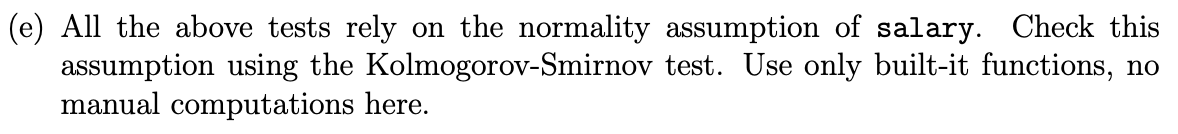

In [16]:
statistic, p_value = stats.kstest(df_ceo["salary"] / df_ceo["salary"].std(), "norm")

print(f"Statistic: {statistic}")
print(f"p value: {p_value}")

Statistic: 0.600770262158486
p value: 7.57362436550446e-155


**Conclusions:**

The resulted statistic is ten times bigger than the one from 1.a, making p value be very close to the zero. This means that the hypothesis (H0) that salary feature is normally distributed can be rejected with any alpha.

## Task 3 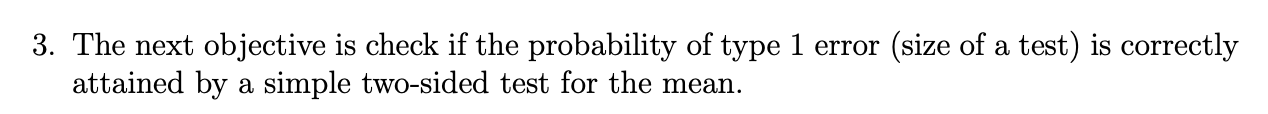

### a) 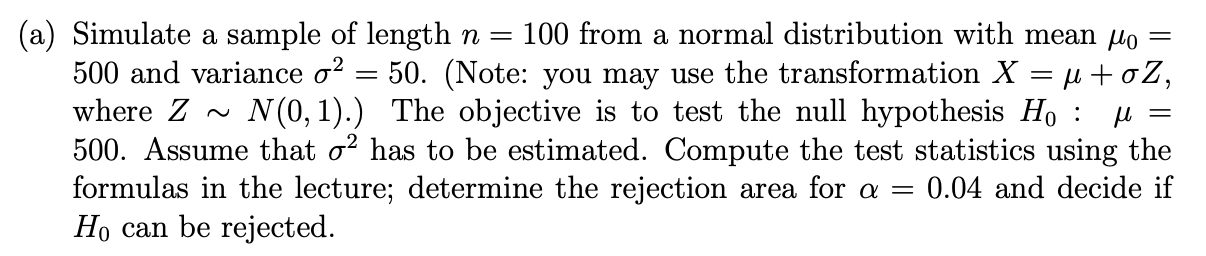

In [17]:
# params
alpha = 0.04
n = 100
sigma = np.sqrt(50)
mu_0 = 500

# generate sample
X = mu_0 + sigma * np.random.normal(0, 1, n)

# calculate the sample mean, sample std
mu = np.mean(X)
s = np.std(X, ddof=1)

# Calculate the z-test statistic
z_statistic = (mu - mu_0) / (s / (n**0.5))

# Calculate the p-value
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_statistic)))

# Calculate the rejection area for a two-sided test
z_critical_lower = stats.norm.ppf(alpha / 2)
z_critical_upper = stats.norm.ppf(1 - alpha / 2)

print("mu:", mu)
print("s:", s)
print("z-statistic:", z_statistic)
print("p-value:", p_value)
print(f"rejection area: B = (-inf; {z_critical_lower}), ({z_critical_upper}; inf)")

mu: 500.0191943944274
s: 6.407386585363334
z-statistic: 0.029956666687261147
p-value: 0.9761016126201889
rejection area: B = (-inf; -2.053748910631823), (2.0537489106318225; inf)


**Conclusions:** 

The statistic and p value vary every run, making it impossible to draw any conclusions. We only can see that with alpha 0.04, number of rejections is much smaller than not rejections.

### b) 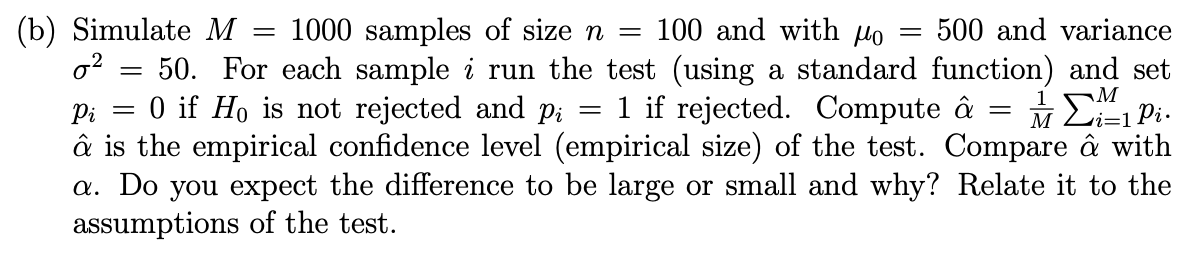

In [18]:
# params
alpha = 0.04
M = 1000
n = 100
mu_0 = 500
sigma = np.sqrt(50)

results = []
for _ in range(0, M):
    # generate sample
    X = mu_0 + sigma * np.random.normal(0, 1, n)

    # calculate the sample mean, sample std
    mu = np.mean(X)
    s = np.std(X, ddof=1)

    # Calculate the z-test statistic
    z_statistic = (mu - mu_0) / (s / (n**0.5))

    # Calculate the p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z_statistic)))

    results.append(p_value < alpha)

empirical_alpha = np.mean(results)
print("Empirical Confidence Level:", empirical_alpha)

Empirical Confidence Level: 0.041


**Conclusions:**

According to the computations, we got the empirical confidence level relatively close to the specified one. This difference was expected to be close as we test the equolity of the means of normally distributed data with the same parameters. So, by the central limit theorem, the means will be normally distributed with N(0;1) and we will select only the alpha part of that distribution which will equal to alpha.

## Task 4 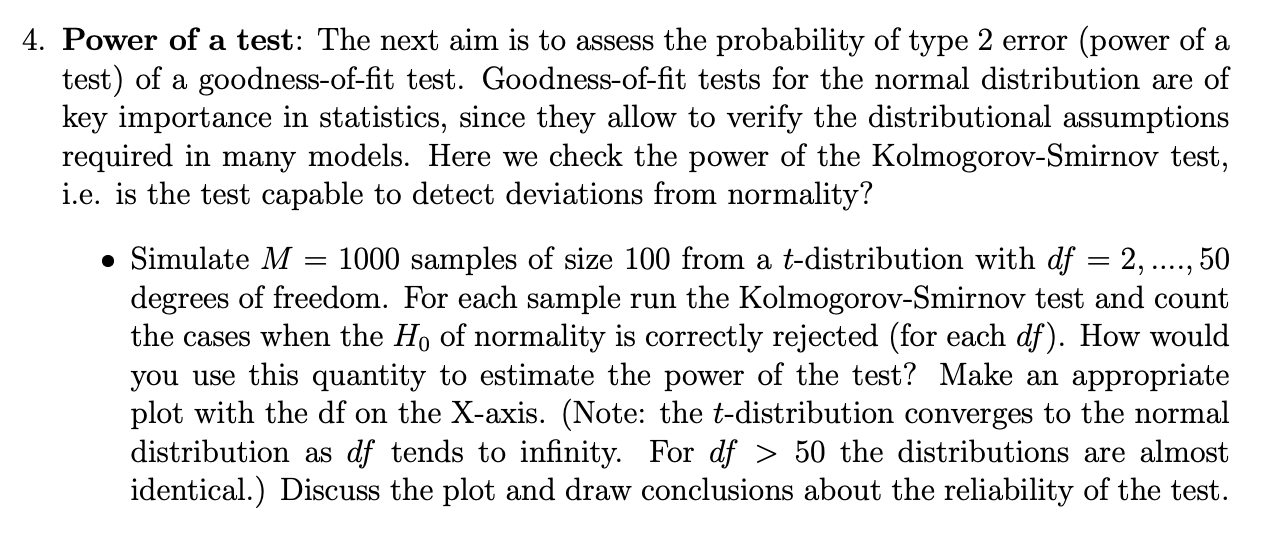

In [19]:
alpha = 0.05
M = 1000
n = 100
dfs = list(range(2, 51))

reject_counts = []
for df in tqdm(dfs):
    rejects = 0
    for _ in range(0, M):
        # generate sample
        sample = stats.t.rvs(df, size=n)
        # run Kolmogorov-Smirnov test
        statistic, p_value = stats.kstest(sample / sample.std(), "norm")
        # check if rejected
        if p_value < alpha:
            rejects += 1
    # find test power = 1 - β = P(reject H0 | H0 is false) - % correctly reject the false H0
    power = rejects / M
    # add summary to list
    reject_counts.append(power)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it]


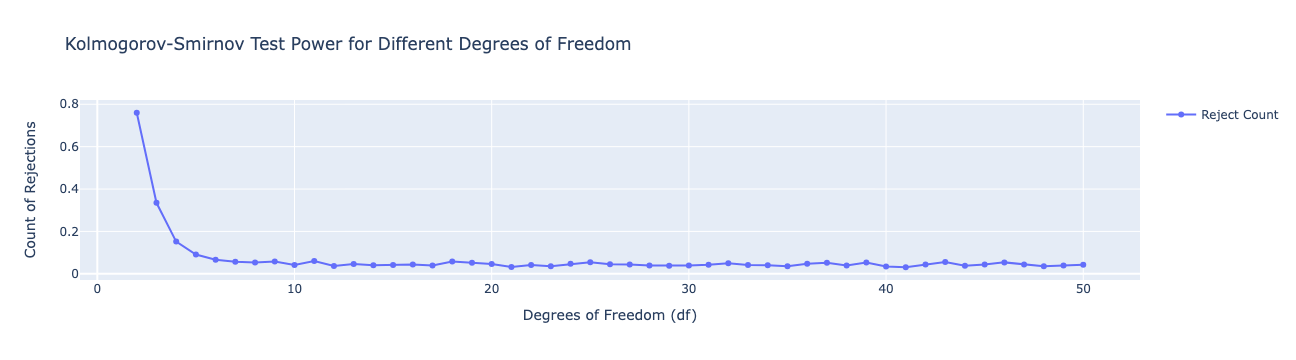

In [20]:
# plot df vs reject counts
fig = go.Figure(
    data=go.Scatter(x=dfs, y=reject_counts, mode="markers+lines", name="Reject Count")
)
fig.update_layout(
    title="Kolmogorov-Smirnov Test Power for Different Degrees of Freedom",
    xaxis_title="Degrees of Freedom (df)",
    yaxis_title="Count of Rejections",
    showlegend=True,
)
fig.show()

**Conclusions:**

According to the plot, we can see that the power of the test remains stable starting from the degrees of freedom equals to 7. We also see that only for degrees of freedom equals to 2 the test shows reliable enough results, having the 76% of simulated samples correctly rejected. Totally, we can conclude that the Kolmogorov-Smirnov test is not reliable in distinguishing the t-distribution from the normal one in the majority of the cases.